In [1]:
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
%config IPCompleter.greedy = True
import numpy as np
import matplotlib.pyplot as plt
import cbpro
import os
from pathlib import Path
import seaborn as sns
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts


# tf.distribute.OneDeviceStrategy(device="/gpu:0")
policy = tf.keras.mixed_precision.Policy("mixed_float16")
tf.keras.mixed_precision.experimental.set_policy(policy)
# np.set_printoptions(suppress=True)

public_client = cbpro.PublicClient()


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


In [2]:
class MinerMeta(type):
    # def __init__(self):
    #     result = getattr(self, "df", None)
    #     if result is None:
    #         self.df = self.compile_historic(read_csv=True)

    def compile_historic(self, num_days=100, write_csv=False, read_csv=False):
        file = Path.cwd() / f"{self.coin}_histdata.csv"
        if read_csv is True:
            df = pd.read_csv(file, index_col="time", infer_datetime_format=True)
            return df
        else:
            finish = datetime.now()
            start = finish - timedelta(num_days)
            delta = timedelta(hours=300)
            df = pd.DataFrame()

            while finish > start:
                historic = public_client.get_product_historic_rates(
                    f"{self.coin}-USD",
                    granularity=3600,
                    start=start,
                    end=start + delta,
                )
                start += delta
                df = df.append(historic, ignore_index=True, verify_integrity=True)
            df.columns = ["time", "low", "high", "open", "close", "volume"]

            # Manual Seasonality Calculation
            # date_time = pd.to_datetime(df["time"], unit="s")
            # df.set_index("time", inplace=True)
            # timestamp_s = date_time.map(pd.Timestamp.timestamp)
            # day = 24 * 60 * 60
            # year = (365.2425) * day
            # df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
            # df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
            # df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
            # df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))

            df.reset_index(drop=True, inplace=True)
            df["time"] = pd.to_datetime(df["time"], unit="s")
            df.set_index("time", inplace=True, verify_integrity=False)
            df.sort_index(ascending=False)
            if write_csv is True:
                df.to_csv(file, index=True)

            return df

    def get_day_stats(self):
        result = getattr(self, "day_stats", None)
        if result is None:
            ticker = public_client.get_product_24hr_stats(f"{self.coin}-USD")
            df = pd.DataFrame.from_dict(ticker, orient="index")
            self.day_stats = df
        return df

    def year_day_fft(self, col):
        df = self.compile_historic()
        today = datetime.today()
        ylim = int(df[col].max())
        plt.figure(figsize=(15, 10))

        fft = tf.signal.rfft(df[col])
        f_per_dataset = np.arange(0, len(fft))

        n_samples_h = 1
        hours_per_year = 24 * 365.2524
        hours_per_week = 24 * 7
        years_per_dataset = n_samples_h / (hours_per_year)
        hours_per_dataset = n_samples_h / (hours_per_week)

        f_per_year = f_per_dataset / years_per_dataset
        f_per_week = f_per_dataset / hours_per_dataset
        plt.step(f_per_week, np.abs(fft))
        plt.xscale("log")
        # plt.ylim(1000, ylim)
        # plt.xlim([0.1, max(plt.xlim())])
        plt.xticks([1, 7], labels=["1/Week", "1/day"])
        plt.xlabel("Frequency (log scale)")

        return plt.show()

    def ttsplit_norm(self, df, split_time=0.7, feature_plot=False):
        # train_df Test Split
        n = len(df)
        train_df = df[0 : int(n * 0.7)]
        val_df = df[int(n * 0.7) : int(n * 0.9)]
        test_df = df[int(n * 0.9) :]
        # Normalize the Data
        train_df_mean = train_df.mean()
        train_df_std = train_df.std()

        train_df = (train_df - train_df_mean) / train_df_std
        val_df = (val_df - train_df_mean) / train_df_std
        test_df = (test_df - train_df_mean) / train_df_std

        # Create Feature Plot if wanted
        if feature_plot is True:
            df_std = (df - train_df_mean) / train_df_std
            df_std = df_std.melt(var_name="Column", value_name="Normalized")
            plt.figure(figsize=(12, 6))
            ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
            ax.set_xticklabels(df.keys(), rotation=90)
            ax.set_title("train_dfing Data Feature Dist with whole DF Mean")

            return train_df, val_df, test_df

        return train_df, val_df, test_df

    def __call__(self, *args, **kwargs):

        cls = type.__call__(self, *args)

        # setattr(cls, "compile_historic", self.compile_historic)
        # setattr(cls, "year_day_fft", self.year_day_fft)
        # setattr(cls, "ttsplit_norm", self.ttsplit_norm)
        # setattr(cls, "get_day_stats", self.get_day_stats)
        # setattr(cls, "day_stats", self.get_day_stats())

        # for key, value in historic.items():
        #     setattr(cls, "hist_" + key, value)
        # for key, value in ticker.items():
        #     setattr(cls, "tick_" + key, value)

        return cls


In [3]:
class eth(metaclass=MinerMeta):
    coin = "eth"


df = eth.compile_historic(num_days=50)


In [4]:
def tt_split(df, train_percent=0.6, val_percent=0.2):
    m = len(df.index)
    train_end = int(train_percent * m)
    val_end = int(val_percent * m) + train_end
    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    # train = (train - train.mean()) / train.std()
    return train, val, test


train, val, test = tt_split(df)
train_label = train.pop("close")
val_label = val.pop("close")
test_label = test.pop("close")


In [5]:
def build_model(observed_time_series):
    hour_of_day_effect = sts.Seasonal(
        num_seasons=24,
        observed_time_series=observed_time_series,
        name="hour_of_day_effect",
    )
    day_of_week_effect = sts.Seasonal(
        num_seasons=7,
        num_steps_per_season=24,
        observed_time_series=observed_time_series,
        name="day_of_week_effect",
    )
    # temperature_effect = sts.LinearRegression(
    #     design_matrix=tf.reshape( - np.mean(temperature), (-1, 1)),
    #     name="temperature_effect",
    # )
    autoregressive = sts.Autoregressive(
        order=1, observed_time_series=observed_time_series, name="autoregressive"
    )
    model = sts.Sum(
        [hour_of_day_effect, day_of_week_effect, autoregressive],
        observed_time_series=observed_time_series,
    )
    return model


model = build_model(train.values)
var_posteriors = tfp.sts.build_factored_surrogate_posterior(model=model)


Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


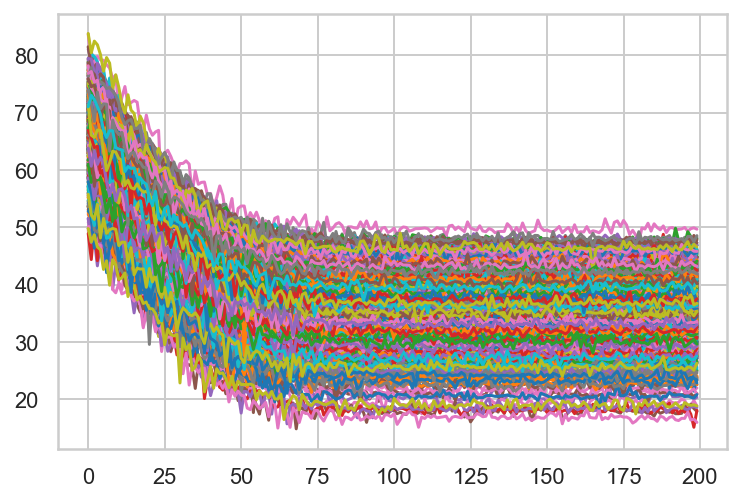

In [6]:
num_var_steps = 200


# @tf.function(experimental_compile=True)
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model.joint_log_prob(observed_time_series=train.values),
    surrogate_posterior=var_posteriors,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=num_var_steps,
    jit_compile=True,
)


# elbo_loss_curve = train()
plt.plot(elbo_loss_curve)
plt.show()


In [7]:
q_samples = var_posteriors.sample(50)

for param in model.parameters:
    print(
        "{}: {} +- {}".format(
            param.name,
            np.mean(q_samples[param.name], axis=0),
            np.std(q_samples[param.name], axis=0),
        )
    )


observation_noise_scale: [2.95252936e+02 1.20743637e+02 1.07194051e+02 1.69923506e+02
 7.35781709e+02 5.93167803e+02 3.20214939e+02 1.51915783e+02
 1.34983684e+02 1.48314497e+02 3.38353268e+01 5.30476833e+01
 1.60281332e+00 1.08867762e+01 3.25098402e+00 2.22152051e+00
 2.21584940e+00 2.08377059e+01 6.51978025e+00 2.92795292e+01
 1.65970458e+02 3.47835429e+00 9.44255435e+00 3.33139458e+01
 1.17120405e+01 9.70866919e+00 1.51517078e+00 2.10173392e+01
 1.57890320e+01 3.22536010e+01 5.13243827e+00 5.60147729e+01
 1.18536445e+01 2.88313246e+00 2.21281517e+01 2.38746292e+01
 2.72887247e+01 2.81539490e+01 4.07027456e+01 3.23296969e+01
 1.47409030e+01 2.13221505e+01 5.40883190e+00 4.17391038e+01
 3.20167508e+02 1.39493926e+01 4.22995953e+01 2.42065469e+02
 1.06380114e+01 7.51578644e+00 2.30800942e+01 1.57586838e+01
 3.08391126e+00 9.10298585e+00 7.23897476e-01 4.21675578e+01
 3.00060045e+00 1.63623066e+01 2.60670222e+01 6.55743289e+00
 9.41394684e+00 3.62333775e+01 6.60424369e+01 4.71393481e+01

In [8]:
forecast = tfp.sts.forecast(
    model,
    observed_time_series=train.values,
    parameter_samples=q_samples,
    num_steps_forecast=24,
)


In [9]:
def plot_forecast(
    x,
    y,
    forecast_mean,
    forecast_scale,
    forecast_samples,
    title=None,
    x_locator=None,
    x_formatter=None,
):
    """Plot a forecast distribution against the 'true' time series."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)

    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast

    ax.plot(x, y, lw=2, color=c1, label="ground truth")

    forecast_steps = np.arange(
        x[num_steps_train],
        int(x[num_steps_train]) + int(num_steps_forecast),
        dtype=x.dtype,
    )

    ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

    ax.plot(forecast_steps, forecast_mean, lw=2, ls="--", color=c2, label="forecast")
    ax.fill_between(
        forecast_steps,
        forecast_mean - 2 * forecast_scale,
        forecast_mean + 2 * forecast_scale,
        color=c2,
        alpha=0.2,
    )

    ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(
        np.max(forecast_samples), np.max(y)
    )
    yrange = ymax - ymin
    ax.set_ylim([ymin - yrange * 0.1, ymax + yrange * 0.1])
    ax.set_title("{}".format(title))
    ax.legend()

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()

    return fig, ax

In [10]:
num_samples = int(10)

forecast_mean, forecast_scale, forecast_samples = (
    forecast.mean().numpy()[..., 0],
    forecast.stddev().numpy()[..., 0],
    forecast.sample(num_samples).numpy()[..., 0],
)

x_loc = mdates.YearLocator(3)
fmt = mdates.DateFormatter("%Y")

fig, ax = plot_forecast(
    train.index,
    train.values,
    forecast_mean,
    forecast_scale,
    forecast_samples,
    # title="Eth Close Forecast",
    # x_locator=x_loc,
    # x_formatter=fmt,
)
# ax.axvline(dates[-num_forecast_steps], linestyle="--")
fig.autofmt_xdate()


ResourceExhaustedError:  OOM when allocating tensor with shape[10,720,50,30] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node forecast_AdditiveStateSpaceModel/sample/forecast_AdditiveStateSpaceModel/sample_n_joint/scan/while/body/_1/forecast_AdditiveStateSpaceModel/sample/forecast_AdditiveStateSpaceModel/sample_n_joint/scan/while/forecast_AdditiveStateSpaceModel_sample_forecast_AdditiveStateSpaceModel_sample_n_joint_scan_while_factored_joint_mvn_MultivariateNormalLinearOperator/sample/forecast_AdditiveStateSpaceModel_sample_forecast_AdditiveStateSpaceModel_sample_n_joint_scan_while_factored_joint_mvn_Sampleforecast_AdditiveStateSpaceModel_sample_forecast_AdditiveStateSpaceModel_sample_n_joint_scan_while_factored_joint_mvn_Normal/sample/transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_sample_24803]

Function call stack:
sample
